# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

Разберём проблему генерации новых имён с помощью рекуррентных нейронных сетей. А именно: сегодня мы напишем рекуррентную нейронную сеть с нуля. А затем мы научим нашу нейронную сеть генерировать новые имена, обучив её на небольшой коллекции. 

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

Для начала, давайте посмотрим на данные, которые у нас есть. Наш датасет состоит из 9000 имён, которые написаны латиницей. В этом это датасете содержатся не только имена, но и фамилии, и при этом — это русские имена. Все имена отсортированы в алфавитном порядке. Каждое имя в нашем датасете будет начинаться с пробела, и вот в этой строке кода мы добавляем пробел перед каждым именем — зачем это делается? Зачем нам нужен пробел перед каждым словом? Если не будет специального символа, с которого начинается генерация, то мы лишим нашу модель способности выбирать первый символ последовательности

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('./datasets/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]
    
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

После того, как мы обучим нашу нейронную сеть, мы сможем генерировать имена, которые соответствуют некоторым условиям — например, имена, которые начинаются на букву "a" или на буквы "abc", или какие-либо другие условия. Если же мы захотим генерировать любые имена, начинающиеся с любой буквы, мы просто передадим нашей функции пробел в качестве первого символа. Таким образом, сможем сгенерировать имена, начинающиеся на любую букву. Давайте теперь посмотрим на распределение длин имён в нашем датасете. Распределение длин имён описывается нормальным распределением и, в целом, большинство имён имеет длину от 6 до 12 символов, что довольно логично и соответствует действительности. При этом, есть имена, которые содержат всего три буквы или содержат аж 18 букв. 

Посмотрим на распределение длин имен:

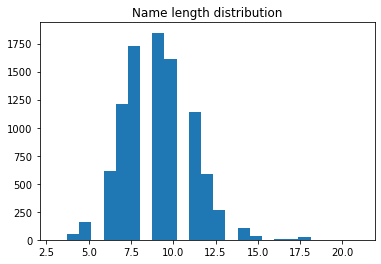

In [4]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

# Препроцессинг
 Теперь нам нужно немного предобработать данные перед тем, как подавать их в нашу нейронную сеть. Нам нужно составить список уникальных символов, которые встречаются в нашем датасете. И посмотрим, сколько уникальных символов есть в нашем датасете: их всего 52.

In [5]:
#all unique characters go here
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  52


### Символы -> id

Создадим словарь < символ > -> < id >

 Теперь нужно создать словарь соответствия буквы некоторому численному ID. Мы не можем подавать в нейросеть буквенный input, нам нужно преобразовать его в некоторое численное представление, поэтому создадим словарь, который будет мапить (map) букву в её численный ID. С помощью этой строки кода создаём словарь, который мы назовём "token_to_id". И теперь мы хотим преобразовать наши входные данные, а именно — наши 9 с небольшим хвостиком тысяч имён в некоторое численное представление, то есть вместо имени мы хотим получить численный вектор. Сделать это мы можем с помощью функций "to_matrix", которая будет преобразовывать наше имя из буквенного, человеко-читаемого формата в формат "вектор с числами". 

In [6]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

In [8]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

Берём 5 имён и смотрим на то, как будет выглядеть матрица для этих 5 имён. Как вы можете видеть, все векторы — одинаковой длины, и при этом все векторы начинаются с одного и того же числа: 29. Это вполне логично, поскольку в начале каждого имени мы ставили пробел, "29" — это ID пробела. При этом, в конце некоторых строк также присутствуют символы "29", один или какое-то большее количество раз. Так происходит потому, что наша функция "to matrix" умеет дополнять слова, которые оказались короче самого длинного слова в коллекции — пробелами в конце, для того, чтобы все слова были одинаковой длины и векторы в нашей матрице имели одинаковую длину. Поэтому в конце некоторых слов вы можете увидеть числа "29", которые соответствуют дополнительным пробелам в конце слов, которые оказались короче самого длинного слова. 

In [9]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[11 40 20 36 20 49  6 11 11 11]
 [11 32 46  8 46 36 31 46 48 47]
 [11 43  4 36  8 49  6 47 11 11]
 [11 24 36 49 46 36 37 49  8 29]
 [11  7  4 13 48 29 49  6 11 11]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

На экране изображение из лекции — основной принцип работы рекуррентной нейронной сети: небольшая схема, которая поможет нам писать код дальше. Будем писать класс "CharRnnCell". У нас есть функции "forward" и есть функция "initial state". "initial state" просто заполняет векторы нулями, выход функции "initial state" соответствует переменной "h0", или нулевому скрытому состоянию нашей нейронной сети. Рассмотрим более подробно, что происходит внутри функции "forward". Для начала мы преобразовываем наши входные векторы в эмбеддинги с помощью слоя, который мы берём из библиотеки pytorch, а именно "nn embedding". Дальше мы конкатенируем текущий входной вектор из переменной "x embedding" и скрытое состояние из предыдущего шага, и дальше, с помощью "rnn update" (именно так мы назвали линейный слой функции "init"), мы делаем следующий шаг — предсказываем следующее скрытое состояние. Дальше в ход идёт нелинейность — мы применяем гиперболический тангенс к выходу этого слоя. В итоге, на выход мы передаём следующее скрытое состояние и вероятности для следующего символа. А именно, мы получим 52 вероятности по каждому символу из нашего словаря.


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

Теперь мы можем переходить в тренировке нашей нейронной сети. После того, как мы написали один шаг RNN, мы можем вызвать его в цикле и предсказывать символы на каждом шаге нашего цикла. Теперь мы можем начинать тренировку нашей сети. Минимизируя кросс-энтропию, либо максимизируя логарифм правдоподобия нашей модели (что — то же самое) — обучать нашу сеть. Берём матрицу ID токенов, сдвинутую на "i" символов влево, так, чтобы именно "i"-ый символ был следующем символом для предсказания на "i"-ом шаге. Такая матрица хранится в переменной "batch index" (аctual_next_tokens = batch_ix[:, 1:]) и, дальше, мы можем переходить к обучению сети. 

In [13]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [14]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

Мы делаем "backward pass" — именно здесь мы вычисляем градиенты нашей лосс-функции по параметрам, делаем шаг с помощью "opt.step" и не забываем сделать "zero_grad", если мы этого не сделаем то градиенты из предыдущих шагов будут накапливаться, аккумулироваться, и это приведёт к неправильному обучению сети. Кроме того, будем визуализировать процесс обучения нашей нейронной сети с помощью библиотеки matplotlib, без каких-либо дополнительных инструментов.     

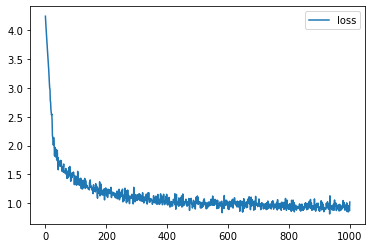

In [15]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Теперь мы можем переходить к генерации имён с помощью обычной RNN-ки. 

### RNN: генерация имен

Давайте попробуем сгенерировать несколько имён! Для этого нам, всего лишь, нужно несколько раз и сделать forward pass в цикле, предсказать несколько символов и сконкатенировать их в одно слово. Посмотрим на 10 имён, которые отсэмплирует наша нейронная сеть.  

In [16]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [17]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Yakrusihilin        
 Dabtakansky         
 Tamseltib           
 Zhkinov             
 Vevityskov          
 Zovalonov           
 Abestekhov          
 Pozuhtanchenko      
 Parmontichviko      
 Adralingv           


Кроме того, мы можем осуществить генерацию имён, которые начинаются с определённого набора символов — например, с букв "АР". И мы получаем фамилии "Араскин", "Ардиский", "Артроев" и некоторые другие. Что ещё мы можем менять при генерации фамилий? Например, мы можем менять такой параметр, как температура. Давайте попробуем поставить её равной "0.2". Получаем какой-то достаточно логичный вывод. Теперь поставим температуру равной "2" и мы видим что-то совсем нелогичное — например, пробелы внутри фамилий или какие-то странные заглавные буквы внутри фамилий. Если же мы поставим совсем маленькую температуру, например "0.01", мы будем получать одну и ту же фамилию каждый раз (практически одну и ту же). Почему так происходит? Если мы ставим маленькую температуру, сеть будет генерировать такие фамилии в которых она наиболее уверена. Оказалось, что наша сеть уверена, что фамилии "Ардуров", "Артамов" и... кажется, всё — это наиболее вероятные фамилии, которые начинаются на буквы "АР". Возможно, они встречались в нашем датасете или были какие-то фамилии, похожие на эти две фамилии. Если же мы ставим большую температуру, то наша сеть будет генерировать очень разнообразный выход, но при этом, зачастую, достаточно нелогичный, потому что она могла выучить некоторые странные особенности нашего датасета. Наша задача — выбрать такую температуру, которая будет обеспечивать достаточное разнообразие нашего датасета и, при этом, генерировать логичные фамилии и логичные имена.

In [18]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Ar'))

 Arshtakovov         
 Arijov              
 Arihovashik         
 Ardeguhhin          
 Ardukotsky          
 Arbo                
 Arzenitonysky       
 Areidechin          
 Arshalulov          
 Artin               


### Более простое решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

В pytorch уже реализована RNN — вы можете просто вызвать из неё "nn.rnncell" или "nn.rnn", и использовать уже готовый модуль для того, чтобы обучить вашу нейронную сеть генерировать новые имена. Здесь будет гораздо меньше кода и, при этом, код будет работать чуть-чуть быстрее, чем на нашей самописной RNN-ке, но, при этом, результат будет примерно такой же. Возьмём pytorch "nn.rnn" и обучим нашу сеть. Здесь мы будем использовать не стохастический градиентный спуск, как это было при обучении в предыдущем блоке, а будем использовать в качестве оптимизатора Adam. И точно так же запустим обучение нашей нейронной сети. С помощью библиотеки pytorch мы можем обучить то же самое, что вы только что написали своими руками, но значительно быстрее и с меньшим количеством кода.


In [19]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [20]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

logp_seq = model(batch_ix)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

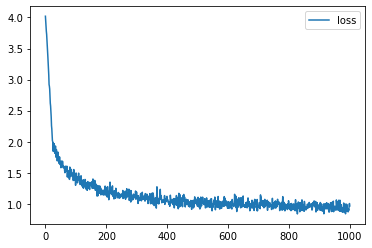

In [21]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [22]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Pobaeffgesko        
 Murukhov            
 Sharuklin           
 Shamonkov           
 Mersyach            
 Labsev              
 Mekraksky           
 Ejev                
 Tzsudom             
 Puchnikhov          


Мы рассмотрели задачу генерацию текстов, а именно — генерации новых имён с помощью рекуррентных нейронных сетей в этом семинаре. Что же ещё можно делать рекуррентными нейронными сетями? Если говорить про генерацию текстов — можно генерировать огромное количество другой информации, например — вы можете генерировать повести, романы, стихи, и будет получаться даже что-то более-менее похожее на логичную прозу или логичную поэзию. Например, очень популярная задача — это генерация поэзии Шекспира, когда RNN-ка обучается на поэзии Шекспира и дальше ваша сеть может генерировать собственные стихи. Кроме того, можно генерировать даже программный код, который вряд ли будет компилироваться или интерпретироваться, но, тем не менее, будет похож на правду. Можно генерировать музыку, новостные заголовки — что угодно ещё. В качестве домашнего задания мы предлагаем вам сгенерировать мотивационные лозунги. А именно, взять данные из файлика, который приложен к этому ноутбуку и называется "author quotes", и попытался научить вашу рекуррентную нейронную сеть генерировать цитаты или какие-то лозунги. Это домашнее задание достаточно простое — всё, что вам нужно — это применить уже готовый код, который мы рассмотрели, в семинаре, к готовым данным и посмотреть на результаты, которые у вас получатся. Возможно немного регулировать температуру генерации, и, в целом, проанализировать результаты, которые вы получите. 

### Домашнее задание: мотивационные лозунги

В качестве домашнего задания мы предлагаем Вам запустить код семинара для решения другой задачи: генерации цитат известных людей. Данные для решения этой задачи Вы можете найти в файле author_quotes.txt.

In [23]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]
print(quotes[:5])

tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)